<a href="https://colab.research.google.com/github/gabyxsantos/Economia/blob/main/trabalho_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Análise Exploratória e Preditiva da Política Monetária Brasileira**

In [ ]:
!pip install numpy==1.24.4 statsmodels==0.13.5
!pip install "pandas>=2.0,<2.3" --upgrade
!pip install babypandas --no-deps
!pip install matplotlib

In [ ]:
import numpy as np
import babypandas as bpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import itertools
import warnings

##**1. Bases de Dados**

###**1.1 Taxa Selic Semestral**

In [ ]:
url_selic = "https://raw.githubusercontent.com/gabyxsantos/Economia/refs/heads/main/base_de_dados/Selic.csv"
dados_selic = pd.read_csv(url_selic, sep=";")

# Renomear coluna da taxa Selic
dados_selic = dados_selic.rename(columns={
    "Taxa de juros nominal - Over / Selic - (% a.a.) - Banco Central do Brasil, Boletim, Seção mercado financeiro e de capitais (Bacen/Boletim/M. Finan.) - PAN12_TJOVER12": "Taxa Selic"
})

# Dropar coluna irrelevante
dados_selic = dados_selic.drop('Unnamed: 2', axis=1)

# Ajustar tipo da taxa Selic
dados_selic['Taxa Selic'] = dados_selic['Taxa Selic'].astype(str)
dados_selic['Taxa Selic'] = dados_selic['Taxa Selic'].str.replace(',', '.', regex=True)
dados_selic['Taxa Selic'] = pd.to_numeric(dados_selic['Taxa Selic'], errors='coerce')

# Converter coluna Data para string
dados_selic['Data_str'] = dados_selic['Data'].astype(str)

# Função para converter para formato YYYYQX
def converter_para_trimestre(valor):
    ano, mes_decimal = valor.split('.')
    mes = int(mes_decimal)
    if mes in [1, 2, 3]:
        trimestre = 'Q1'
    elif mes in [4, 5, 6]:
        trimestre = 'Q2'
    elif mes in [7, 8, 9]:
        trimestre = 'Q3'
    else:
        trimestre = 'Q4'
    return f"{ano}{trimestre}"

# Aplicar a função na coluna Data
dados_selic['Data'] = dados_selic['Data_str'].apply(converter_para_trimestre)

# Remover coluna auxiliar
dados_selic = dados_selic.drop(columns=['Data_str'])

# Agrupar por trimestre (YYYYQX) e tirar a média, removendo repetições
dados_selic = dados_selic.groupby('Data', as_index=False)['Taxa Selic'].mean()

# Renomeia coluna
dados_selic = dados_selic.rename(columns={'Data':'Trimestre'})

# Mostrar resultado
dados_selic


,Trimestre,Taxa Selic
0,1974Q1,15.711943
1,1974Q2,17.055855
2,1974Q3,17.276066
3,1974Q4,20.925704
4,1975Q1,20.968529
...,...,...
201,2024Q2,10.516350
202,2024Q3,10.998928
203,2024Q4,10.825927
204,2025Q1,12.504433


###**1.2 Desocupação**

####**1.2.1 Desocupação por grupo etário**

In [ ]:
url_desocupacaoIdade = "https://raw.githubusercontent.com/gabyxsantos/Economia/refs/heads/main/base_de_dados/desocupacaoIdade.csv"
dados_desocupacaoIdade = pd.read_csv(url_desocupacaoIdade, sep=";", skiprows=1, header=None)
dados_desocupacaoIdade = dados_desocupacaoIdade.drop(index=7, columns=1)
dados_desocupacaoIdade

,0,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
0,Grupo de idade,1º trimestre 2012,2º trimestre 2012,3º trimestre 2012,4º trimestre 2012,1º trimestre 2013,2º trimestre 2013,3º trimestre 2013,4º trimestre 2013,1º trimestre 2014,...,4º trimestre 2022,1º trimestre 2023,2º trimestre 2023,3º trimestre 2023,4º trimestre 2023,1º trimestre 2024,2º trimestre 2024,3º trimestre 2024,4º trimestre 2024,1º trimestre 2025
1,14 a 17 anos,24.8,22.1,20.4,19.6,24.8,22.8,20.8,18.6,22.2,...,29,33.1,29.8,30.2,28.2,30.2,28.2,25.1,24.7,26.4
2,18 a 24 anos,16.1,15.3,14.1,13.8,16,15.1,14.7,12.8,15.3,...,16.4,18,16.6,16,15.3,16.8,14.3,13.4,12.9,14.9
3,25 a 39 anos,7.1,7,6.6,6.5,7.5,7.1,6.5,5.9,6.5,...,7.1,8.2,7.4,7,6.9,7.3,6.3,5.9,5.8,6.5
4,40 a 59 anos,4,3.6,3.6,3.4,4,3.8,3.4,3.2,3.7,...,5.3,5.6,5.3,5.1,4.9,5.2,4.6,4.1,4,4.7
5,60 anos ou mais,2.1,2.2,1.7,2,2.1,1.8,1.9,1.6,2.1,...,3.4,3.9,3.4,3.2,3.5,3.2,3.1,3,3,3.1
6,Total,8,7.6,7.1,6.9,8.1,7.5,7,6.3,7.2,...,7.9,8.8,8,7.7,7.4,7.9,6.9,6.4,6.2,7


####**1.2.2 Desocupação por sexo**

In [ ]:
url_desocupacaoSexo = "https://raw.githubusercontent.com/gabyxsantos/Economia/refs/heads/main/base_de_dados/desocupacaoSexo.csv"
dados_desocupacaoSexo = pd.read_csv(url_desocupacaoSexo, sep=";", skiprows=1, header=None)
dados_desocupacaoSexo = dados_desocupacaoSexo.drop(index=4, columns=1)
dados_desocupacaoSexo

,0,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
0,Sexo,1º trimestre 2012,2º trimestre 2012,3º trimestre 2012,4º trimestre 2012,1º trimestre 2013,2º trimestre 2013,3º trimestre 2013,4º trimestre 2013,1º trimestre 2014,...,4º trimestre 2022,1º trimestre 2023,2º trimestre 2023,3º trimestre 2023,4º trimestre 2023,1º trimestre 2024,2º trimestre 2024,3º trimestre 2024,4º trimestre 2024,1º trimestre 2025
1,Homens,6.2,6.1,5.8,5.7,6.5,6,5.7,5.1,5.9,...,6.5,7.2,6.9,6.4,6,6.5,5.6,5.3,5.1,5.7
2,Mulheres,10.5,9.6,9,8.5,10.2,9.5,8.9,7.8,9,...,9.8,10.8,9.6,9.3,9.2,9.8,8.6,7.7,7.6,8.7
3,Total,8,7.6,7.1,6.9,8.1,7.5,7,6.3,7.2,...,7.9,8.8,8,7.7,7.4,7.9,6.9,6.4,6.2,7


####**1.2.3 Desocupação total**

In [ ]:
url_txDesocupacao = "https://raw.githubusercontent.com/gabyxsantos/Economia/refs/heads/main/base_de_dados/taxaDesocupacao.csv"
dados_txDesocupacao = pd.read_csv(url_txDesocupacao, sep=";", skiprows=1, header=None)
dados_txDesocupacao = dados_txDesocupacao.drop(index = 2)
dados_txDesocupacao

# Mapa para converter nomes dos meses para números
mes_map = {
    "jan": 1, "fev": 2, "mar": 3, "abr": 4, "mai": 5, "jun": 6,
    "jul": 7, "ago": 8, "set": 9, "out": 10, "nov": 11, "dez": 12
}

def col_to_quarter(col_name):
    if not isinstance(col_name, str):
        return col_name

    if " " not in col_name:
        return col_name

    partes = col_name.split()
    if len(partes) < 2:
        return col_name

    meses = partes[0].split('-')
    if len(meses) != 3:
        return col_name

    ano = partes[1]
    mes_central = meses[1].lower()
    mes_num = mes_map.get(mes_central, None)
    if mes_num is None:
        return col_name

    trimestre = (mes_num - 1) // 3 + 1
    return f"{ano}Q{trimestre}"

# URL da base de dados
url_txDesocupacao = "https://raw.githubusercontent.com/gabyxsantos/Economia/refs/heads/main/base_de_dados/taxaDesocupacao.csv"

# Leitura do CSV, pulando a primeira linha e sem header
dados_txDesocupacao = pd.read_csv(url_txDesocupacao, sep=";", skiprows=1, header=None)

# Removendo a linha de índice 2 que está suja/dentro do arquivo original
dados_txDesocupacao = dados_txDesocupacao.drop(index=2)

# Criar lista das novas colunas, renomeando só a partir da 2ª coluna
novas_colunas = ['Localidade'] + [col_to_quarter(x) for x in dados_txDesocupacao.loc[0][1:]]

# Atribuir as colunas ao dataframe
dados_txDesocupacao.columns = novas_colunas

# Remover a linha 0 que estava com os nomes antigos das colunas
dados_txDesocupacao = dados_txDesocupacao.drop(index=0).reset_index(drop=True)



# Separar a coluna Localidade
df_ident = dados_txDesocupacao[['Localidade']]

# Pegar só as colunas de valores (trimestres)
df_values = dados_txDesocupacao.drop(columns=['Localidade'])

# Converter para numérico, ignorando erros
df_values = df_values.apply(pd.to_numeric, errors='coerce')

# Transpor, agrupar por nome (que viram linhas), tirar a média, e voltar a transpor
df_mean = df_values.T.groupby(df_values.columns).mean().T

# Juntar a coluna Localidade de volta
df_final = pd.concat([df_ident, df_mean], axis=1)

df_transposed = df_final.set_index('Localidade').T.reset_index()

# Renomear colunas: 'Localidade' vira 'Trimestre', 'Brasil' vira 'Desocupação(%)'
dados_desemprego = df_transposed.rename(columns={'index': 'Trimestre', 'Brasil': 'Desocupação(%)'})

dados_desemprego


Localidade,Trimestre,Desocupação(%)
0,2012Q1,7.900000
1,2012Q2,7.600000
2,2012Q3,7.166667
3,2012Q4,6.850000
4,2013Q1,7.933333
...,...,...
49,2024Q2,6.933333
50,2024Q3,6.400000
51,2024Q4,6.633333
52,2025Q1,6.800000


###**1.3 Rendimento médio**

In [ ]:
url_rendMedio = "https://raw.githubusercontent.com/gabyxsantos/Economia/refs/heads/main/base_de_dados/rendimentoMedio.csv"
dados_rendMedio = pd.read_csv(url_rendMedio, sep=";", skiprows=1, header=None)
dados_rendMedio = dados_rendMedio.drop(index = 2)
dados_rendMedio

,0,1,2,3,4,5,6,7,8,9,...,149,150,151,152,153,154,155,156,157,158
0,,jan-fev-mar 2012,fev-mar-abr 2012,mar-abr-mai 2012,abr-mai-jun 2012,mai-jun-jul 2012,jun-jul-ago 2012,jul-ago-set 2012,ago-set-out 2012,set-out-nov 2012,...,mai-jun-jul 2024,jun-jul-ago 2024,jul-ago-set 2024,ago-set-out 2024,set-out-nov 2024,out-nov-dez 2024,nov-dez-jan 2025,dez-jan-fev 2025,jan-fev-mar 2025,fev-mar-abr 2025
1,Brasil,2999,3010,3002,3009,3024,3034,3029,3025,3022,...,3343,3360,3349,3368,3383,3397,3414,3427,3436,3426


###**1.4 Gastos primários do governo**

In [ ]:
import pandas as pd
import requests
from io import BytesIO

anos = range(2009, 2025)
base_url = "https://github.com/gabyxsantos/Economia/raw/main/base_de_dados/gastos{}.xlsx"

dfs = []

for ano in anos:
    url = base_url.format(ano)
    print(f"Lendo {ano}...")
    try:
        response = requests.get(url)
        df = pd.read_excel(BytesIO(response.content))
        df['ID_ANO'] = ano

        # Converter PAGAMENTOS_TOTAIS para número (remover pontos, trocar vírgulas por ponto)
        df['PAGAMENTOS_TOTAIS'] = (
            df['PAGAMENTOS_TOTAIS']
            .astype(str)
            .str.replace('.', '', regex=False)
            .str.replace(',', '.', regex=False)
            .astype(float)
        )

        # Criar coluna TRIMESTRE (1 a 4)
        df['TRIMESTRE'] = ((df['ID_MES'] - 1) // 3) + 1

        dfs.append(df)
    except Exception as e:
        print(f"Erro ao ler {ano}: {e}")

# Concatenar todos os anos
df_final = pd.concat(dfs, ignore_index=True)

# Filtrar só despesas primárias
df_primaria = df_final[df_final['PRIMARIA_FINANCEIRA'] == 'Primária']

# Agrupar por ano e trimestre somando os pagamentos
dados_gastos = (
    df_primaria
    .groupby(['ID_ANO', 'TRIMESTRE'])['PAGAMENTOS_TOTAIS']
    .sum()
    .reset_index()
)

# Criar coluna Trimestre no formato YYYYQX
dados_gastos['Trimestre'] = dados_gastos.apply(
    lambda row: f"{int(row['ID_ANO'])}Q{int(row['TRIMESTRE'])}", axis=1
)

# Selecionar colunas finais para o merge
dados_gastos = dados_gastos[['Trimestre', 'PAGAMENTOS_TOTAIS']]

# Renomear coluna para facilitar identificação
dados_gastos = dados_gastos.rename(columns={'PAGAMENTOS_TOTAIS': 'Gastos Primários (R$)'})

dados_gastos

Lendo 2009...
Lendo 2010...
Lendo 2011...
Lendo 2012...
Lendo 2013...
Lendo 2014...
Lendo 2015...
Lendo 2016...
Lendo 2017...
Lendo 2018...
Lendo 2019...
Lendo 2020...
Lendo 2021...
Lendo 2022...
Lendo 2023...
Lendo 2024...


,Trimestre,Gastos Primários (R$)
0,2009Q1,1.535795e+13
1,2009Q2,1.478589e+13
2,2009Q3,1.448610e+13
3,2009Q4,1.703555e+13
4,2010Q1,1.655958e+13
...,...,...
59,2023Q4,6.796594e+13
60,2024Q1,1.679323e+16
61,2024Q2,3.254719e+16
62,2024Q3,2.736252e+16


###**1.5 Crescimento do PIB**

####**1.5.1 PIB Anual**

In [ ]:
PIB=pd.read_excel("https://github.com/gabyxsantos/Economia/raw/refs/heads/main/base_de_dados/PIB%20(1).xls")

# Pega a transposta
PIB=PIB.T
colunas_para_remover=PIB.columns[[0,2,3]]
# Remove colunas desnecessárias
PIB=PIB.drop(colunas_para_remover,axis=1)
PIB=PIB.reset_index()
# Renomeia as colunas com o valor da primeira linha
for i in range(0, PIB.shape[1]):
    PIB.rename(columns={PIB.columns[i]: PIB.iloc[0, i]}, inplace=True)
PIB = PIB.drop(0)
PIB=PIB.rename(columns={'Real GDP growth (Annual percent change)':'Ano','Brazil':'Cresc_PIB'})
PIB

,Ano,Cresc_PIB
1,1980,9.2
2,1981,-4.4
3,1982,0.6
4,1983,-3.4
5,1984,5.3
...,...,...
47,2026,2.0
48,2027,2.2
49,2028,2.3
50,2029,2.4


####**1.5.2 PIB Trimestral**

In [ ]:
url = "https://raw.githubusercontent.com/gabyxsantos/Economia/main/base_de_dados/PIB_Trimestral.csv"

df = pd.read_csv(url, sep=";", skiprows=1)

def trimestre_to_YYYYQX(text):
    parts = text.split()
    if len(parts) == 3:
        tri_num = parts[0][0]
        ano = parts[2]
        return f"{ano}Q{tri_num}"
    else:
        return text

novas_colunas = [df.columns[0]] + [trimestre_to_YYYYQX(col) for col in df.columns[1:]]
df.columns = novas_colunas

dados_PIB = df.set_index(df.columns[0]).T.reset_index()
dados_PIB = dados_PIB.rename(columns={"index": "Trimestre", "Brasil": "PIB (%)"})
dados_PIB = dados_PIB.drop(columns=['Fonte: "IBGE - Contas Nacionais Trimestrais"'])

dados_PIB

,Trimestre,PIB (%)
0,1996Q1,2.5
1,1996Q2,2.1
2,1996Q3,2.3
3,1996Q4,2.2
4,1997Q1,3.2
...,...,...
112,2024Q1,2.8
113,2024Q2,2.7
114,2024Q3,3.1
115,2024Q4,3.4


###**1.5.3 PIB Per Capita**

In [ ]:
PIB_PC=pd.read_excel("https://raw.githubusercontent.com/gabyxsantos/Economia/main/base_de_dados/PIB_PC%20(1).xls", engine="xlrd")

# Pega a transposta
PIB_PC=PIB_PC.T
colunas_para_remover=PIB_PC.columns[[0,2,3]]
# Remove colunas desnecessárias
PIB_PC=PIB_PC.drop(colunas_para_remover,axis=1)
PIB_PC=PIB_PC.reset_index()
# Renomeia as colunas com o valor da primeira linha
for i in range(0, PIB_PC.shape[1]):
    PIB_PC.rename(columns={PIB_PC.columns[i]: PIB_PC.iloc[0, i]}, inplace=True)
PIB_PC = PIB_PC.drop(0)
PIB_PC=PIB_PC.rename(columns={'GDP per capita, current prices\n (U.S. dollars per capita)':'Ano','Brazil':'PIB Per Capita (U$)'})
PIB_PC

,Ano,PIB Per Capita (U$)
1,1980,1229.883
2,1981,1382.548
3,1982,1446.228
4,1983,1134.932
5,1984,1105.852
...,...,...
47,2026,10215.584
48,2027,10697.469
49,2028,11208.539
50,2029,11774.535


###**1.6 Taxa de Inflação**

####**1.6.1 Inflação anual**

In [ ]:
Inflacao=pd.read_excel("https://raw.githubusercontent.com/gabyxsantos/Economia/main/base_de_dados/Inflacao_Brasil%20(1).xls", engine="xlrd")

# Pega a transposta
Inflacao=Inflacao.T
colunas_para_remover=Inflacao.columns[[0,2,3]]
# Remove colunas desnecessárias
Inflacao=Inflacao.drop(colunas_para_remover,axis=1)
Inflacao=Inflacao.reset_index()
# Renomeia as colunas com o valor da primeira linha
for i in range(0, Inflacao.shape[1]):
    Inflacao.rename(columns={Inflacao.columns[i]: Inflacao.iloc[0, i]}, inplace=True)
Inflacao = Inflacao.drop(0)
Inflacao=Inflacao.rename(columns={'Inflation rate, end of period consumer prices (Annual percent change)':'Ano','Brazil':'Inflação (%)'})
Inflacao

,Ano,Inflação (%)
1,1980,no data
2,1981,95.7
3,1982,104.8
4,1983,164.0
5,1984,215.3
...,...,...
47,2026,3.9
48,2027,3.0
49,2028,3.0
50,2029,3.0


####**1.6.2 Inflação trimestral**

In [ ]:
# URL do arquivo CSV no formato RAW
url = "https://raw.githubusercontent.com/gabyxsantos/Economia/main/base_de_dados/ipca_202503SerieHist%20(1).csv"

# Lê os dados pulando o cabeçalho inicial irrelevante
df = pd.read_csv(url, encoding="latin1", sep=",", skiprows=7)

# Renomeia as colunas
df.columns = ["ANO", "MÊS", "ÍNDICE", "VAR_MÊS", "VAR_3_MESES", "VAR_6_MESES", "VAR_ANO", "VAR_12_MESES"]

# Remove linhas totalmente vazias
df = df.dropna(how="all")

# Remove linhas onde 'VAR_MÊS' é NaN
df = df[df["VAR_MÊS"].notna()].copy()

# Limpa a coluna e filtra apenas valores numéricos válidos
df["VAR_MÊS"] = (
    df["VAR_MÊS"]
    .str.replace(",", ".")
    .str.replace(" ", "")
    .str.replace("(%", "", regex=False)
    .str.replace(")", "", regex=False)
)

# Filtra apenas valores numéricos válidos
df = df[df["VAR_MÊS"].str.match(r"^-?\d+(\.\d+)?$")].copy()

# Preenche os anos ausentes com o último valor válido
df["ANO"] = df["ANO"].ffill()

# Converte inflação para float
df["VAR_MÊS"] = df["VAR_MÊS"].astype(float)

# Mapeia os meses
meses = {
    "JAN": 1, "FEV": 2, "MAR": 3, "ABR": 4, "MAI": 5, "JUN": 6,
    "JUL": 7, "AGO": 8, "SET": 9, "OUT": 10, "NOV": 11, "DEZ": 12
}
df["MÊS_NUM"] = df["MÊS"].map(meses)

# Cria coluna de data
df["DATA"] = pd.to_datetime(dict(
    year=df["ANO"].astype(int),
    month=df["MÊS_NUM"],
    day=1
))

# Cria coluna de trimestre no formato string "YYYYQX"
df["TRIMESTRE"] = df["DATA"].dt.year.astype(str) + "Q" + df["DATA"].dt.quarter.astype(str)

# Agrupa por trimestre somando a inflação mensal
dados_inflacao = df.groupby("TRIMESTRE")["VAR_MÊS"].sum().reset_index()
dados_inflacao.columns = ["Trimestre", "Inflação Acumulada (%)"]

# Ordena corretamente os trimestres
dados_inflacao["Ano"] = dados_inflacao["Trimestre"].str.extract(r"(\d{4})").astype(int)
dados_inflacao["Q"] = dados_inflacao["Trimestre"].str.extract(r"Q([1-4])").astype(int)
dados_inflacao = dados_inflacao.sort_values(by=["Ano", "Q"]).drop(columns=["Ano", "Q"]).reset_index(drop=True)

# Exibe o resultado
dados_inflacao

,Trimestre,Inflação Acumulada (%)
0,1994Q1,124.33
1,1994Q2,134.14
2,1994Q3,10.23
3,1994Q4,7.14
4,1995Q1,4.27
...,...,...
120,2024Q1,1.41
121,2024Q2,1.05
122,2024Q3,0.80
123,2024Q4,1.47


##**2. Análise Exploratória das Variáveis Econômicas**

Como tema central do nosso trabalho, objetivamos investigar como a taxa Selic afeta o mercado e o quanto fatores como desemprego, inflação, gastos governamentais e PIB estão relacionados com esta.

####**2.1 Inflação x Taxa Selic**

É de conhecimento público, que o Banco Central analisa a inflação atual e as expectativas futuras, e com base nessa análise e na meta de inflação, o BC define a Taxa Selic. Ou seja, se o Banco Central percebe que a inflação está acima da meta ou que as expectativas de inflação futura estão desancoradas (ou seja, as pessoas e o mercado esperam que a inflação continue alta), ele tende a aumentar a taxa, tendo como objetivo, justamente, esfriar a economia e trazer a inflação para a meta.

Com base nisso, nossa expectativa é conseguir, ao plotar os gráficos, ver uma relação clara de causa e efeito entre os índices abordados.

Para essa análise, seguiremos os seguintes passos:

* Formatação dos dados, ajustando os períodos temporais
* Análise dos gráficos de linha de maneira isolada
* Verificar quão for é a correlação entre as variáveis



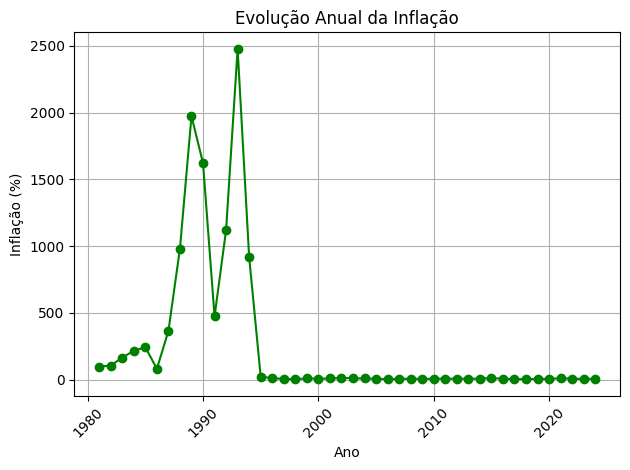

In [ ]:
inflacao_anual = Inflacao[(Inflacao['Ano'] > 1980) & (Inflacao['Ano'] < 2025)]

plt.plot(inflacao_anual['Ano'], inflacao_anual['Inflação (%)'], marker='o', linestyle='-', color='green')
plt.title('Evolução Anual da Inflação')
plt.xlabel('Ano')
plt.ylabel('Inflação (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

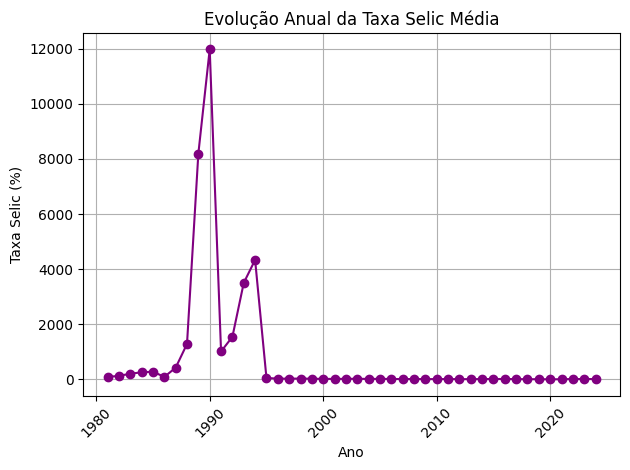

In [ ]:
selic_anual = dados_selic.copy()

# Garante que a coluna 'Data' seja string
selic_anual['Trimestre'] = selic_anual['Trimestre'].astype(str)

# Extrai apenas o ano dos valores no formato 'YYYYQX'
selic_anual['Ano'] = selic_anual['Trimestre'].str[:4].astype(int)

# Agrupa por ano e calcula a média da Selic
selic_anual = (
    selic_anual
    .groupby('Ano')['Taxa Selic']
    .mean()
    .reset_index()
)

# Filtra o intervalo de anos desejado
selic_anual = selic_anual[(selic_anual['Ano'] > 1980) & (selic_anual['Ano'] < 2025)]

# Gráfico
plt.plot(selic_anual['Ano'], selic_anual['Taxa Selic'], marker='o', linestyle='-', color='purple')
plt.title('Evolução Anual da Taxa Selic Média')
plt.xlabel('Ano')
plt.ylabel('Taxa Selic (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Por Que Taxas Tão Altas Antes dos anos 2000?**

Antes dos anos 2000, principalmente antes de 1994, a hiperinflação era algo constante e impactante no Brasil, sendo causada por:

*   Governo gastando demais e imprimindo dinheiro para pagar as contas.
*   Tudo na economia (preços, salários) sendo automaticamente reajustado pela inflação passada, criando um ciclo vicioso.

Nesse cenário, as taxas de juros (como a Selic) eram altíssimas apenas para tentar proteger o dinheiro da rápida perda de valor pela inflação. Eram mais um sintoma da doença do que uma ferramenta de controle eficaz, pois a inflação era estrutural.

**Novo espaço temporal:**
O ponto de virada da economia brasileira ocorreu com O Plano Real (1994). Essa estratégia multifacetada combateu a inflação em suas raízes, atuando em frentes como o ajuste fiscal, a desindexação da economia (com a URV) e a introdução de uma nova moeda (o Real) com forte credibilidade. Temdo isso em mente, buscando uma análise mais recente e adequada, restringiremos nosso espaço temporal das tabelas aos anos posteriores a 2000, considerando alguns anos após a criação do Plano Real, visto que o país precisou se estabilizar.

In [ ]:
inflacao_anual = inflacao_anual[(inflacao_anual['Ano'] > 1999) & (inflacao_anual['Ano'] < 2025)].reset_index(drop=True)
selic_anual = selic_anual[(selic_anual['Ano'] > 1999) & (selic_anual['Ano'] < 2025)].reset_index(drop=True)

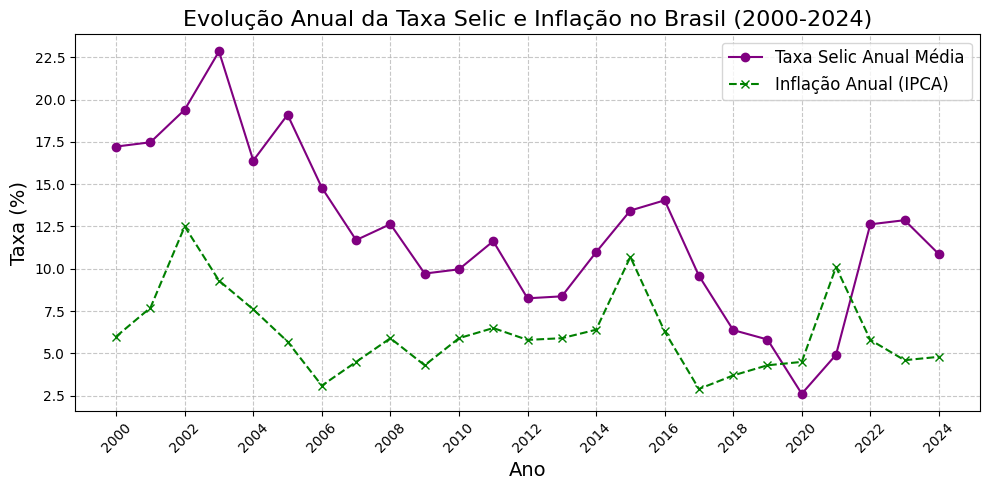

In [ ]:
selic_anual['Ano'] = selic_anual['Ano'].astype(int)
inflacao_anual['Ano'] = inflacao_anual['Ano'].astype(int)
selic_anual['Taxa Selic'] = selic_anual['Taxa Selic'].astype(float)
inflacao_anual['Inflação (%)'] = inflacao_anual['Inflação (%)'].astype(float)

#juntando os dfs
selic_inflacao = pd.merge(selic_anual, inflacao_anual, on='Ano')

plt.figure(figsize=(10, 5))
plt.plot(selic_inflacao['Ano'], selic_inflacao['Taxa Selic'],
         label='Taxa Selic Anual Média', marker='o', linestyle='-', color='purple')
plt.plot(selic_inflacao['Ano'], selic_inflacao['Inflação (%)'],
         label='Inflação Anual (IPCA)', marker='x', linestyle='--', color='green')

plt.title('Evolução Anual da Taxa Selic e Inflação no Brasil (2000-2024)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Taxa (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(selic_inflacao['Ano'][::2], rotation=45)
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()

In [ ]:
selic_inflacao

,Ano,Taxa Selic,Inflação (%)
0,2000,17.220654,6.0
1,2001,17.473713,7.7
2,2002,19.399358,12.5
3,2003,22.839047,9.3
4,2004,16.392748,7.6
...,...,...,...
20,2020,2.616727,4.5
21,2021,4.920510,10.1
22,2022,12.626998,5.8
23,2023,12.870867,4.6


Correlação entre a Taxa Selic e a Inflação (normalizada): 0.43


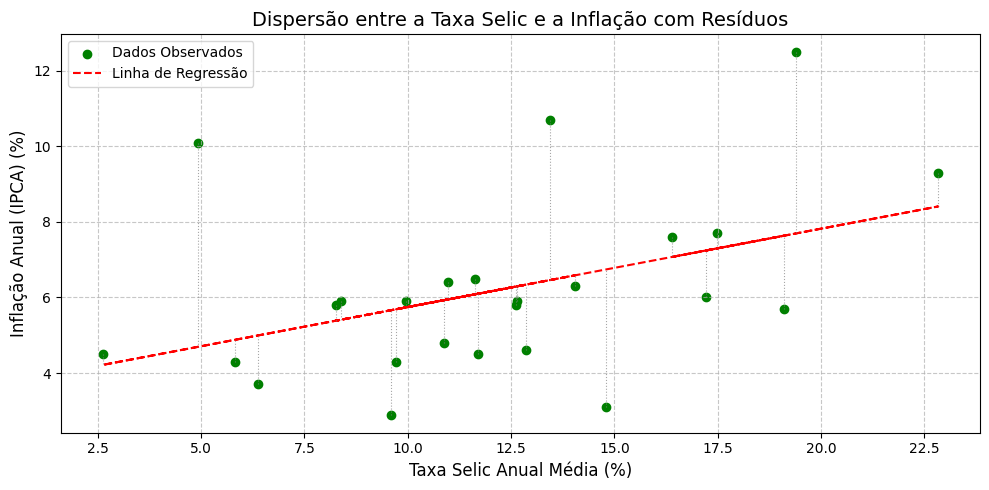

In [ ]:
selic_inflacao['Taxa Selic Normalizada'] = (selic_inflacao['Taxa Selic'] - selic_inflacao['Taxa Selic'].mean()) / selic_inflacao['Taxa Selic'].std()
selic_inflacao['Inflação (%) Normalizada'] = (selic_inflacao['Inflação (%)'] - selic_inflacao['Inflação (%)'].mean()) / selic_inflacao['Inflação (%)'].std()

correlacao = selic_inflacao['Taxa Selic Normalizada'].corr(selic_inflacao['Inflação (%) Normalizada'])
print(f'Correlação entre a Taxa Selic e a Inflação (normalizada): {correlacao:.2f}')

x = selic_inflacao['Taxa Selic']
y = selic_inflacao['Inflação (%)']

m, b = np.polyfit(x, y, 1)

y_predito = m * x + b

plt.figure(figsize=(10, 5))

plt.scatter(x, y, color='green', label='Dados Observados')

plt.plot(x, y_predito, color='red', linestyle='--', label='Linha de Regressão')

for i in range(len(x)):
    plt.plot([x.iloc[i], x.iloc[i]], [y.iloc[i], y_predito.iloc[i]],
             color='gray', linestyle=':', linewidth=0.8, alpha=0.7)

plt.xlabel('Taxa Selic Anual Média (%)', fontsize=12)
plt.ylabel('Inflação Anual (IPCA) (%)', fontsize=12)
plt.title('Dispersão entre a Taxa Selic e a Inflação com Resíduos', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

**Por que a Correlação Pode ser "Baixa" (0.40)?**

Uma correlação linear de Pearson de 0.40 indica uma correlação linear positiva moderada, não uma correlação fraca. Isso significa que, quando a Selic sobe, a inflação tende a subir um pouco, e vice-versa. Mas por que não é mais forte, como 0.8 ou 0.9?

A relação entre Selic e inflação não é um simples "causa e efeito" imediato e perfeitamente linear, por várias razões:


*   **Defasagem Temporal (Lags):** A política monetária age com defasagem. Quando o Banco Central aumenta a Selic para combater a inflação, os efeitos na economia (redução do consumo, desaquecimento da produção) levam tempo para aparecer, geralmente de 6 a 18 meses. Portanto, a inflação que o BC está combatendo hoje é a do passado recente, e a Selic de hoje afetará a inflação futura. Se você correlaciona a Selic de um ano com a inflação do mesmo ano, essa defasagem mascara a verdadeira relação.
*   **A inflação é multifatorial:** Justamente como próposito do nosso trabalho, queremos abordar a relçao da Selic com diversos parâmetros, sendo esperado esta seja afetada e afete mais fatores, não sendo determinada apenas pela inflação.

#### **2.2 Gastos do governo X Selic**

Outro fator que pode influenciar as decisões de política monetária é a situação fiscal do país, especialmente os gastos primários do governo.

Os gastos primários, que representam as despesas do governo com saúde, educação, previdência, programas sociais e outros serviços públicos (excluindo o pagamento de juros da dívida), exercem impacto sobre a economia ao afetarem diretamente a demanda agregada. Quando esses gastos crescem de forma significativa, podem gerar pressões inflacionárias e aumentar a percepção de risco fiscal, o que, por sua vez, pode influenciar o Banco Central a elevar a taxa Selic como forma de conter desequilíbrios.

Com base nesse contexto, nossa expectativa é que, ao plotar os gráficos das séries históricas de gastos primários e da taxa Selic, seja possível identificar uma relação de causa e efeito, ainda que indireta, entre essas variáveis.



**Leitura dos dados relacionados aos gastos do governo por ano:**

In [ ]:
import pandas as pd
import requests
from io import BytesIO

anos = range(2009, 2025)  # Ajuste os anos conforme necessário
base_url = "https://github.com/gabyxsantos/Economia/raw/main/base_de_dados/gastos{}.xlsx"

dfs = []

for ano in anos:
    url = base_url.format(ano)
    print(f"Lendo {ano}...")
    try:
        response = requests.get(url)
        df = pd.read_excel(BytesIO(response.content))
        df['Ano'] = ano
        dfs.append(df)
    except Exception as e:
        print(f"Erro ao ler {ano}: {e}")

# Junta todos os anos em um único DataFrame
df_final = pd.concat(dfs, ignore_index=True)

# Filtra só as despesas primárias
df_final = df_final[df_final['PRIMARIA_FINANCEIRA'] == 'Primária']

# Agrupa por ano e soma os pagamentos
gastos_por_ano = df_final.groupby('Ano')['PAGAMENTOS_TOTAIS'].sum().reset_index()
gastos_por_ano.columns = ['Ano', 'Gastos Primários (R$ bilhões)']

print(gastos_por_ano)



Lendo 2009...
Lendo 2010...
Lendo 2011...
Lendo 2012...
Lendo 2013...
Lendo 2014...
Lendo 2015...
Lendo 2016...
Lendo 2017...
Lendo 2018...
Lendo 2019...
Lendo 2020...
Lendo 2021...
Lendo 2022...
Lendo 2023...
Lendo 2024...
     Ano  Gastos Primários (R$ bilhões)
0   2009                   7.021818e+11
1   2010                   7.986640e+11
2   2011                   8.942526e+11
3   2012                   9.843979e+11
4   2013                   1.092414e+12
..   ...                            ...
11  2020                   2.187897e+12
12  2021                   1.963357e+12
13  2022                   2.247991e+12
14  2023                   2.561069e+12
15  2024                   2.706323e+12

[16 rows x 2 columns]


In [ ]:
gastos_por_ano

,Ano,Gastos Primários (R$ bilhões)
0,2009,7.021818e+11
1,2010,7.986640e+11
2,2011,8.942526e+11
3,2012,9.843979e+11
4,2013,1.092414e+12
...,...,...
11,2020,2.187897e+12
12,2021,1.963357e+12
13,2022,2.247991e+12
14,2023,2.561069e+12


**Taxa Selic:**

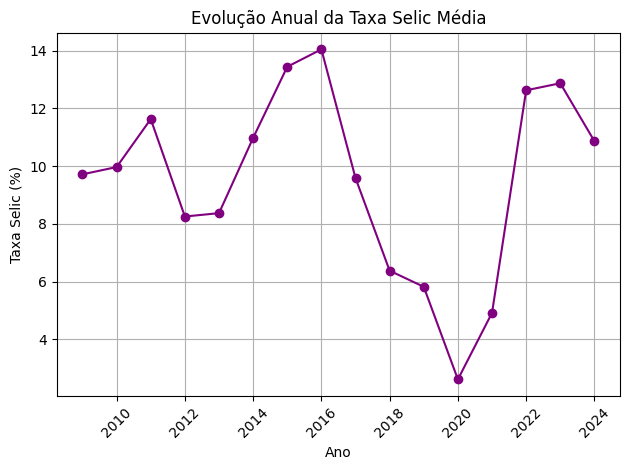

In [ ]:
selic_anual = dados_selic.copy()

# Garante que a coluna 'Data' seja string
selic_anual['Trimestre'] = selic_anual['Trimestre'].astype(str)

# Extrai apenas o ano dos valores no formato 'YYYYQX'
selic_anual['Ano'] = selic_anual['Trimestre'].str[:4].astype(int)

# Agrupa por ano e calcula a média da Selic
selic_anual = (
    selic_anual
    .groupby('Ano')['Taxa Selic']
    .mean()
    .reset_index()
)

# Filtra o intervalo de anos desejado
selic_anual = selic_anual[(selic_anual['Ano'] > 2008) & (selic_anual['Ano'] < 2025)]

# Gráfico
plt.plot(selic_anual['Ano'], selic_anual['Taxa Selic'], marker='o', linestyle='-', color='purple')
plt.title('Evolução Anual da Taxa Selic Média')
plt.xlabel('Ano')
plt.ylabel('Taxa Selic (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Gastos Primários do Governo por Ano:**

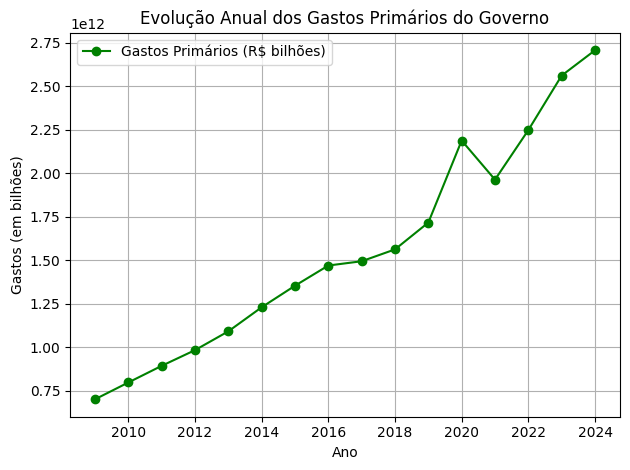

In [ ]:
# Plotando os gastos anuais em verde
gastos_por_ano.plot(kind='line',
                    x='Ano',
                    y='Gastos Primários (R$ bilhões)',
                    marker='o',
                    color='green')

# Melhorando a visualização
plt.title('Evolução Anual dos Gastos Primários do Governo')
plt.xlabel('Ano')
plt.ylabel('Gastos (em bilhões)')
plt.grid(True)
plt.tight_layout()

plt.show()


Os gastos primários do governo apresentam uma tendência clara de crescimento entre 2009 e 2024, refletida no aumento constante dos valores nominais. Esse crescimento pode ser atribuído a fatores como inflação acumulada, ampliação dos programas sociais e aumento da máquina pública.

Especialmente nos últimos anos, observa-se uma aceleração no ritmo de crescimento dos gastos, possivelmente ligada a medidas emergenciais para enfrentar crises econômicas recentes. (Crises, como a pandemia de COVID-19, fizeram o governo aumentar gastos para sustentar a economia.)



Em suma, o crescimento expressivo dos gastos primários indica um aumento da participação do governo na economia.

In [ ]:
#Junção dos 2 Data Frames (Gastos do Governo e Selic)
selic_gastos_governo = pd.merge(selic_anual, gastos_por_ano, on='Ano')

In [ ]:
selic_gastos_governo

,Ano,Taxa Selic,Gastos Primários (R$ bilhões)
0,2009,9.717796,7.021818e+11
1,2010,9.969349,7.986640e+11
2,2011,11.630347,8.942526e+11
3,2012,8.256396,9.843979e+11
4,2013,8.372885,1.092414e+12
...,...,...,...
11,2020,2.616727,2.187897e+12
12,2021,4.920510,1.963357e+12
13,2022,12.626998,2.247991e+12
14,2023,12.870867,2.561069e+12


<Figure size 1000x500 with 0 Axes>

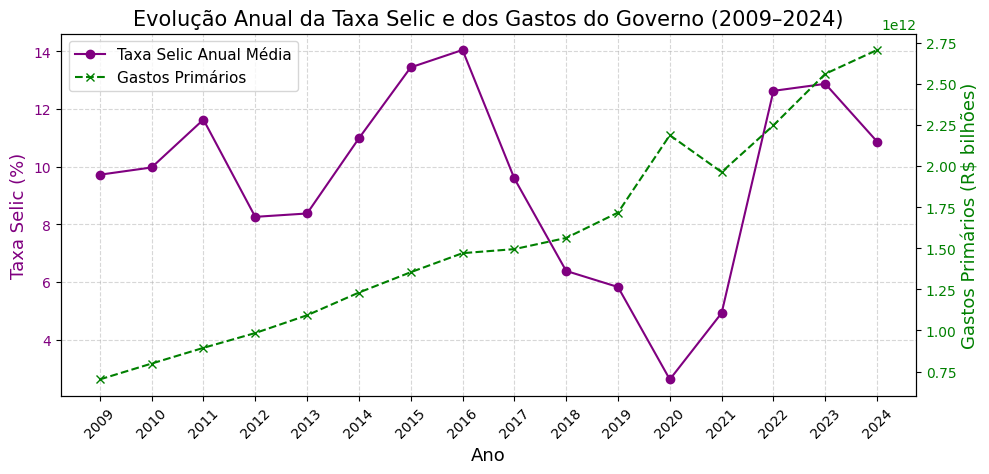

In [ ]:
import matplotlib.pyplot as plt

# Figura
plt.figure(figsize=(10, 5))

# Eixo principal: Taxa Selic
fig, ax1 = plt.subplots(figsize=(10, 5))

# Eixo secundário: Gastos Primários
ax2 = ax1.twinx()

# Plot Taxa Selic
ax1.plot(selic_gastos_governo['Ano'], selic_gastos_governo['Taxa Selic'],
         label='Taxa Selic Anual Média', marker='o', linestyle='-', color='purple')
ax1.set_ylabel('Taxa Selic (%)', fontsize=13, color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Plot Gastos Primários
ax2.plot(selic_gastos_governo['Ano'], selic_gastos_governo['Gastos Primários (R$ bilhões)'],
         label='Gastos Primários', marker='x', linestyle='--', color='green')
ax2.set_ylabel('Gastos Primários (R$ bilhões)', fontsize=13, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Eixo X e Título
ax1.set_xlabel('Ano', fontsize=13)
ax1.set_title('Evolução Anual da Taxa Selic e dos Gastos do Governo (2009–2024)', fontsize=15)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xticks(selic_gastos_governo['Ano'])
ax1.set_xticklabels(selic_gastos_governo['Ano'], rotation=45)

# Legenda (combinar de ambos os eixos)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11)

plt.tight_layout()
plt.show()


A partir desse gráfico podemos ver que não há uma relação tão clara e direta entre as duas variáveis analisadas. Há muitos períodos em que os gastos sobem e a Selic cai (ou vice-versa).

Exemplos:

- 2020 (pandemia): Gastos primários explodiram (auxílio emergencial, saúde). Selic caiu para mínima histórica (aprox 2%) — pois a demanda estava fraca e havia risco de recessão.

- 2022: Gastos estavam de certa forma mais controlados (fim do auxílio emergencial temporário), mas a inflação subiu muito. Logo, o Banco Central aumentou a Selic fortemente.

Correlação entre a Taxa Selic e a Inflação (normalizada): -0.07


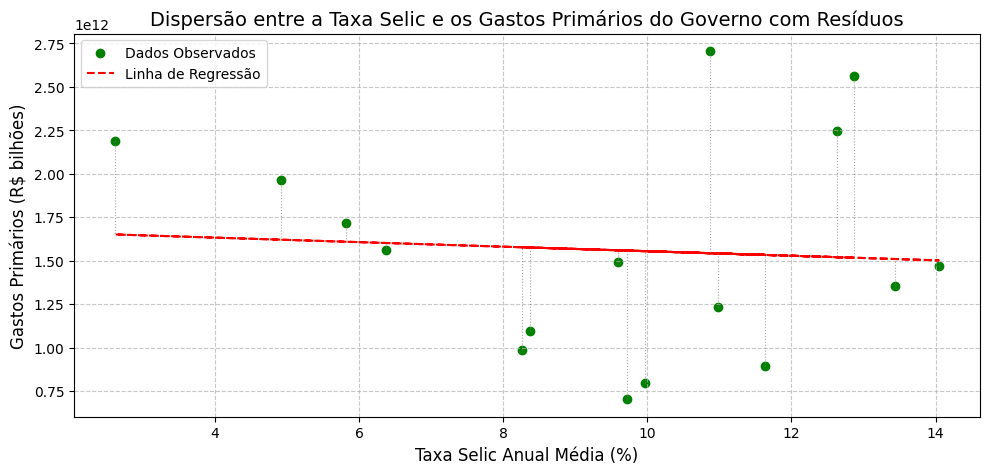

In [ ]:
selic_gastos_governo['Taxa Selic Normalizada'] = (selic_gastos_governo['Taxa Selic'] - selic_gastos_governo['Taxa Selic'].mean()) / selic_gastos_governo['Taxa Selic'].std()
selic_gastos_governo['Gastos Primários Normalizados'] = (selic_gastos_governo['Gastos Primários (R$ bilhões)'] - selic_gastos_governo['Gastos Primários (R$ bilhões)'].mean()) / selic_gastos_governo['Gastos Primários (R$ bilhões)'].std()

correlacao = selic_gastos_governo['Taxa Selic Normalizada'].corr(selic_gastos_governo['Gastos Primários Normalizados'])
print(f'Correlação entre a Taxa Selic e a Inflação (normalizada): {correlacao:.2f}')

x = selic_gastos_governo['Taxa Selic']
y = selic_gastos_governo['Gastos Primários (R$ bilhões)']

m, b = np.polyfit(x, y, 1)

y_predito = m * x + b

plt.figure(figsize=(10, 5))

plt.scatter(x, y, color='green', label='Dados Observados')

plt.plot(x, y_predito, color='red', linestyle='--', label='Linha de Regressão')

for i in range(len(x)):
    plt.plot([x.iloc[i], x.iloc[i]], [y.iloc[i], y_predito.iloc[i]],
             color='gray', linestyle=':', linewidth=0.8, alpha=0.7)

plt.xlabel('Taxa Selic Anual Média (%)', fontsize=12)
plt.ylabel('Gastos Primários (R$ bilhões)', fontsize=12)
plt.title('Dispersão entre a Taxa Selic e os Gastos Primários do Governo com Resíduos', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Os dados históricos analisados entre 2009 e 2024 indicam uma correlação linear muito fraca e negativa entre os gastos primários do governo e a taxa Selic média anual, com coeficiente de correlação de aproximadamente -0,07.

Esse valor mostra que a relação entre gastos do governo e a taxa básica de juros não é direta nem estável.

**Por que deu uma correlação tão baixa (praticamente nula)?**
1. Muitos outros fatores influenciam a Selic

  A Selic não responde diretamente ao nível dos gastos públicos, mas sim à:

  - Inflação atual e esperada

  - Credibilidade do governo

  - Expectativas do mercado

  - Cenário internacional

  Mesmo que os gastos aumentem, a Selic pode cair se a inflação estiver controlada ou se houver confiança na política fiscal.

2. Gastos primários são pouco voláteis ano a ano

  Os gastos seguem uma trajetória relativamente estável (crescem quase sempre), enquanto a Selic varia muito mais ao longo do tempo, com ciclos de alta e queda.

  Isso reduz a chance de uma relação estatística forte entre as curvas.

3. Momentos de política anticíclica

  Em vários momentos, o governo aumenta gastos (para estimular a economia) enquanto o BC reduz a Selic — como em crises.

  Ex: Pandemia (2020)

  Isso pode produzir uma leve correlação negativa, mas ela não é estrutural nem consistente.



Embora a hipótese inicial fosse de uma possível relação positiva entre gastos públicos e política monetária, os dados analisados não sustentam uma correlação forte ou estável. Isso reforça a ideia de que a taxa Selic responde a um conjunto mais amplo de variáveis, enquanto os gastos primários isoladamente têm influência limitada e indireta sobre a condução da política monetária e não explicam de forma significativa as variações na Selic, e vice-versa.



####**2.4 Análise Preditiva da Taxa Selic**

Após observarmos as correlações entre variáveis macroeconômicas relevantes — como taxa de desemprego, crescimento percentual do PIB, inflação acumulada e gastos primários do governo — com a Taxa Selic, avançamos para uma abordagem preditiva, a fim de entender se tais variáveis poderiam antecipar movimentos da principal taxa de juros da economia brasileira.

Para esse propósito, empregamos modelos da classe SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors), que combinam:

* Componentes autorregressivos (AR, parâmetro p), que modelam a dependência da série com seus próprios valores passados;

* Componentes de diferença (I, parâmetro d), que tratam de eventuais tendências não estacionárias;

* Componentes de média móvel (MA, parâmetro q), que capturam padrões nos erros da previsão;

E, opcionalmente, variáveis exógenas, que são fatores externos à série principal e podem contribuir para sua previsão.

O modelo foi treinado com os dados trimestrais médios da Selic no intervalo entre 2012 e 2022, enquanto os dados dos anos de 2023 e 2024 foram utilizados para validação e teste, de forma a avaliar a capacidade de generalização do modelo. Durante o processo, testamos diversas combinações de parâmetros (p,d,q) e subconjuntos das variáveis exógenas mencionadas. O objetivo foi encontrar o modelo com o menor erro de previsão (RMSE) na fase de validação, equilibrando desempenho com complexidade.

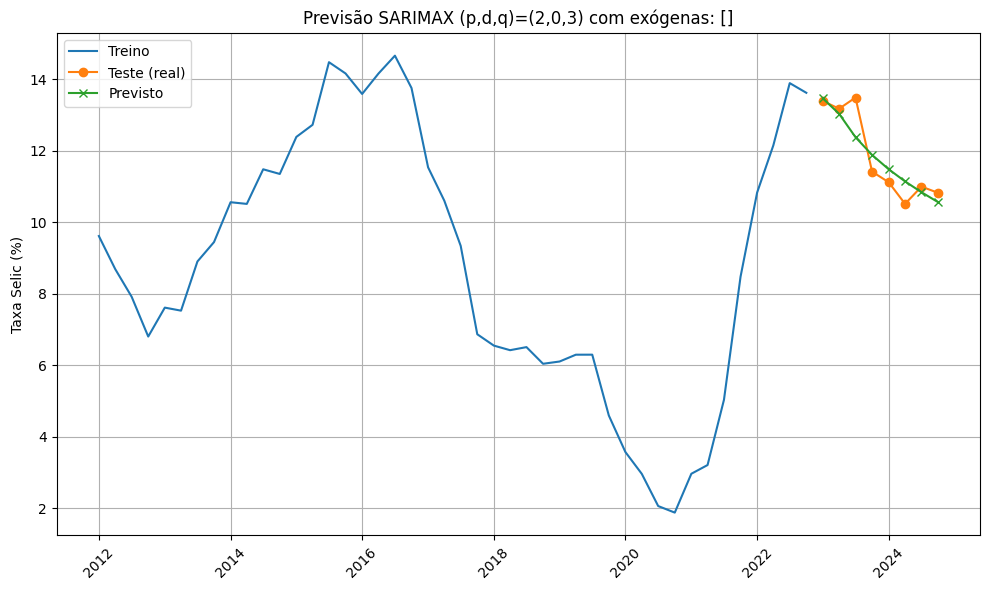

In [ ]:
warnings.filterwarnings("ignore")

# --- Montagem dos dados e ordenação ---
base = pd.merge(dados_selic, dados_desemprego, on='Trimestre')
base = pd.merge(base, dados_PIB, on='Trimestre')
base = pd.merge(base, dados_inflacao, on='Trimestre')
base = pd.merge(base, dados_gastos, on='Trimestre')
base = base.sort_values(by='Trimestre').reset_index(drop=True)

# Definir série alvo e exógenas
y = base[['Trimestre', 'Taxa Selic']].copy()
y.set_index('Trimestre', inplace=True)

exog_vars = ['Desocupação(%)', 'PIB (%)', 'Inflação Acumulada (%)', 'Gastos Primários (R$)']
exog = base[['Trimestre'] + exog_vars].copy()
exog.set_index('Trimestre', inplace=True)

# Converter índice para PeriodIndex trimestral
y.index = pd.PeriodIndex(y.index, freq='Q')
exog.index = pd.PeriodIndex(exog.index, freq='Q')

# Separar treino e teste
y_train = y.loc[:'2022Q4']
y_test = y.loc['2023Q1':]

exog_train = exog.loc[y_train.index]
exog_test = exog.loc[y_test.index]

# Valores de p, d, q
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

# Função para testar modelo
def teste_modelo_arima(p, d, q, exog_subset):
    try:
        if exog_subset:
            exog_train_sub = exog_train[list(exog_subset)]
            exog_test_sub = exog_test[list(exog_subset)]
        else:
            exog_train_sub = None
            exog_test_sub = None

        model = sm.tsa.SARIMAX(y_train, order=(p,d,q), exog=exog_train_sub,
                               enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        y_pred = results.predict(start=y_test.index[0], end=y_test.index[-1], exog=exog_test_sub)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return rmse, results.aic
    except:
        return np.inf, np.inf

# Testar todas combinações de p, d, q e exógenas
resultados = []
for p, d, q in itertools.product(p_values, d_values, q_values):
    for r in range(len(exog_vars) + 1):
        for subset in itertools.combinations(exog_vars, r):
            rmse, aic = teste_modelo_arima(p, d, q, subset)
            resultados.append({
                'p': p,
                'd': d,
                'q': q,
                'exog_vars': subset,
                'RMSE': rmse,
                'AIC': aic,
                'ordem_soma': p + d + q,
                'num_exog': len(subset)
            })

# Resultados em DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados[df_resultados['RMSE'] != np.inf]
df_resultados = df_resultados.sort_values(by=['RMSE', 'ordem_soma', 'num_exog'])

# Melhor modelo simples
melhor = df_resultados.iloc[0]

# Ajuste do modelo final
p, d, q = melhor['p'], melhor['d'], melhor['q']
exog_final_vars = list(melhor['exog_vars'])

if exog_final_vars:
    exog_train_final = exog_train[exog_final_vars]
    exog_test_final = exog_test[exog_final_vars]
else:
    exog_train_final = None
    exog_test_final = None

modelo_final = sm.tsa.SARIMAX(y_train, order=(p, d, q), exog=exog_train_final,
                              enforce_stationarity=False, enforce_invertibility=False)
resultados_final = modelo_final.fit(disp=False)

# Previsão
y_pred_final = resultados_final.predict(start=y_test.index[0], end=y_test.index[-1], exog=exog_test_final)

# Plot
plt.figure(figsize=(10,6))
plt.plot(y_train.index.to_timestamp(), y_train.values, label='Treino')
plt.plot(y_test.index.to_timestamp(), y_test.values, label='Teste (real)', marker='o')
plt.plot(y_pred_final.index.to_timestamp(), y_pred_final.values, label='Previsto', marker='x')
plt.title(f'Previsão SARIMAX (p,d,q)=({p},{d},{q}) com exógenas: {exog_final_vars}')
plt.ylabel('Taxa Selic (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Resultado Observado**

Curiosamente, o modelo com melhor desempenho preditivo — aquele que mais se aproximou dos valores reais da Selic em 2023 e 2024 — não utilizou nenhuma variável exógena. Ou seja, o modelo ideal foi um ARMA puro, que se baseia apenas no comportamento passado da própria Selic para prever seus valores futuros.

Embora esse resultado possa parecer contraintuitivo à primeira vista, ele pode ser compreendido à luz da natureza da própria Taxa Selic:

1. A Selic é um instrumento de política monetária, definida pelo Comitê de Política Monetária (Copom) do Banco Central, com decisões baseadas não apenas em indicadores observáveis, mas também em expectativas de mercado, projeções econômicas, metas de inflação e cenários futuros;

2. Por ser fortemente autoregressiva, a Selic tende a apresentar trajetórias suaves, com mudanças graduais. O histórico da taxa incorpora boa parte da resposta a choques macroeconômicos e da estratégia do Banco Central;

3. As variáveis exógenas usadas, embora relacionadas à Selic, não refletem a totalidade dos fatores considerados nas decisões do Copom, como expectativas inflacionárias futuras, risco fiscal, cenário externo ou mesmo fatores geopolíticos;

4. Finalmente, o intervalo trimestral e o número limitado de observações podem dificultar que o modelo capte relações complexas entre as variáveis exógenas e a Selic. Esses efeitos podem ser defasados, não-lineares ou dependentes de regimes econômicos (por exemplo, períodos de crise vs. estabilidade).

A seguir, estendemos o intervalo de treino até o último trimestre de 2024, utilizando o modelo SARIMAX(2,0,3) previamente selecionado. O período de teste foi definido como todos os trimestres de 2025, com o objetivo de projetar o comportamento da taxa SELIC ao longo do ano vigente:

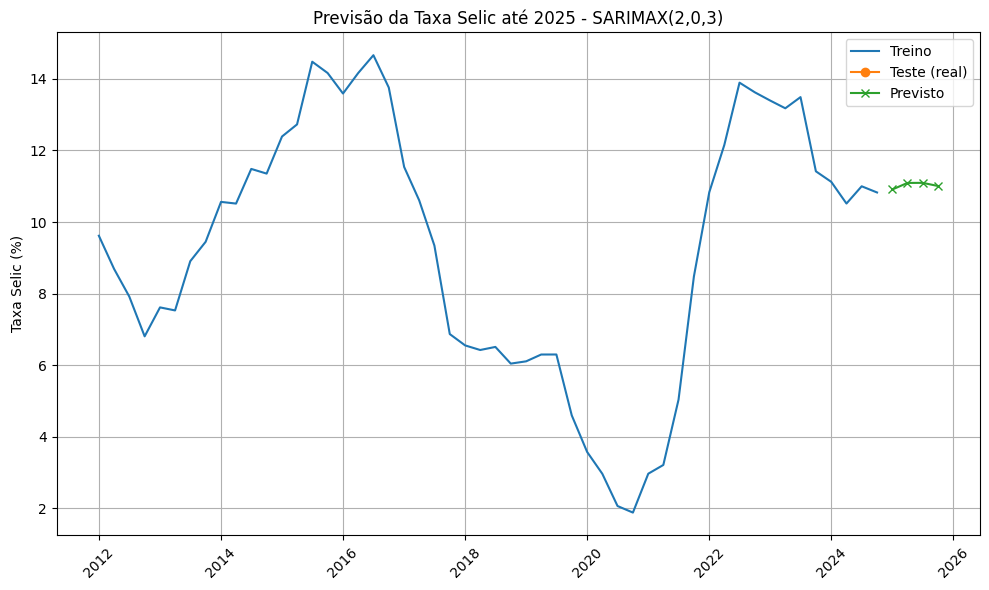

In [ ]:
# Novo treino até 2024Q4
y_train = y.loc[:'2024Q4']

# Prever os trimestres de 2025 (assumindo que temos até 2025Q4 na base)
y_test = y.loc['2025Q1':]

# Ajustar modelo com dados até 2024
modelo = sm.tsa.SARIMAX(y_train, order=(2, 0, 3),
                        enforce_stationarity=False, enforce_invertibility=False)
resultado = modelo.fit(disp=False)

# Previsão para 2025
y_pred = resultado.predict(start='2025Q1', end='2025Q4')

# Plot dos dados desde 2012 até 2025
plt.figure(figsize=(10,6))
plt.plot(y_train.index.to_timestamp(), y_train.values, label='Treino')
plt.plot(y_test.index.to_timestamp(), y_test.values, label='Teste (real)', marker='o')
plt.plot(y_pred.index.to_timestamp(), y_pred.values, label='Previsto', marker='x')
plt.title('Previsão da Taxa Selic até 2025 - SARIMAX(2,0,3)')
plt.ylabel('Taxa Selic (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Resultado Observado**

A projeção gerada pelo modelo indica a manutenção da SELIC em torno de 11% durante 2025. No entanto, essa estimativa diverge significativamente da realidade observada, em que a taxa alcança 14,75%, evidenciando limitações do modelo em capturar os fatores que impulsionaram a recente elevação da taxa básica de juros.

Essa discrepância pode ser atribuída a diversos fatores externos ao escopo do modelo:

* O risco fiscal vigente e seu impacto na adoção de uma política mais contracionista por parte do Banco Central.

* Possíveis choques exógenos não capturados pelas variáveis do modelo, como oscilações abruptas no preço de commodities.

* Limitações estruturais do modelo ARMA, que assume estabilidade e linearidade nos dados, dificultando a modelagem de comportamentos abruptos ou não-lineares típicos de ambientes macroeconômicos voláteis.

#####**Limitações gerais do modelo**

Apesar de ser amplamente utilizado em séries temporais, o SARIMAX possui algumas limitações importantes que devem ser consideradas:

* Incapacidade de capturar mudanças estruturais: como choques políticos, crises internacionais ou mudanças bruscas na política econômica, a menos que explicitamente modelados.

* Sazonalidade limitada: apesar de o modelo permitir componentes sazonais, eles são mais eficazes em séries com sazonalidade evidente (como vendas no varejo). No caso da Selic, não há uma sazonalidade cíclica tão marcada.

* Sensibilidade a dados faltantes e multicolinearidade: variáveis exógenas altamente correlacionadas entre si podem gerar instabilidade no ajuste, e o modelo também não lida bem com gaps nos dados.

* Volume de dados: para modelos com muitas variáveis exógenas ou componentes sazonais, é ideal trabalhar com uma série longa. No caso deste experimento, a limitação temporal (2012–2024) impôs um teto à complexidade do modelo sem risco de superajuste.

####**2.5. Análise Preditiva do Desemprego**

A taxa de desocupação (desemprego) é um dos principais indicadores econômicos observados pelo Banco Central no processo de definição da taxa SELIC, que é a taxa básica de juros da economia brasileira. Essa relação se dá porque, ao aumentar a SELIC, o Banco Central tende a desestimular o consumo e o investimento, o que contribui para reduzir a pressão inflacionária. Entretanto, essa desaceleração econômica geralmente vem acompanhada de efeitos colaterais no mercado de trabalho, como o arrefecimento da criação de vagas ou até mesmo o aumento da desocupação.

Sob esse viés, torna-se estrategicamente relevante antecipar o comportamento da taxa de desemprego, uma vez que ela pode sinalizar mudanças no ciclo monetário e no nível de atividade econômica. A previsão desse indicador permite, portanto, análises mais robustas sobre o cenário macroeconômico futuro, ajudando tanto formuladores de política pública quanto agentes de mercado a tomar decisões fundamentadas.


**Modelo Holt-Winters**

Para estimar a trajetória da taxa de desocupação, utilizou-se o modelo Holt-Winters com suavização exponencial, uma técnica consagrada para séries temporais com sazonalidade e tendência. Esse modelo é composto por três componentes principais:

* **Nível (Level)** – o valor médio da série no tempo atual;

* **Tendência (Trend)** – a direção (crescente ou decrescente) que a série segue;

* **Sazonalidade (Seasonality)** – padrões que se repetem em ciclos regulares (por exemplo, variações trimestrais na taxa de desemprego).

Neste caso, utilizou-se a versão multiplicativa do modelo, tanto para a tendência quanto para a sazonalidade, o que é apropriado para séries em que a magnitude das variações sazonais cresce ou decresce proporcionalmente ao nível da série.

**Período de treino e de teste**

* **Período de treino:** 2012Q1 a 2023Q4 (12 anos de dados trimestrais, capturando ciclos completos do mercado de trabalho, inclusive o impacto da recessão de 2015-16 e da pandemia de COVID-19).

* **Período de teste (previsão):** 2024Q1 a 2025Q1, totalizando 5 trimestres à frente da base observada.

A previsão foi gerada com base nos padrões históricos observados durante o período de treino, buscando capturar as flutuações sazonais recorrentes e a tendência estrutural da taxa de desocupação nos últimos anos.

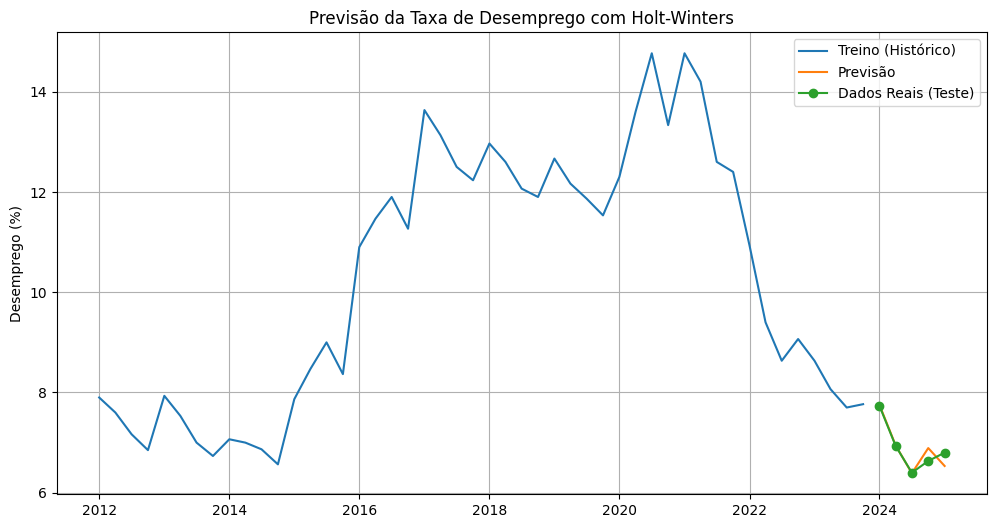

RMSE: 0.1661
MAE: 0.1131


In [ ]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Copiar o DataFrame original para não alterar
df_temp = dados_desemprego.copy()

# Criar coluna auxiliar com PeriodIndex
df_temp['Periodo'] = pd.PeriodIndex(df_temp['Trimestre'], freq='Q')

# Indexar pelo período e ordenar
df_temp.set_index('Periodo', inplace=True)
df_temp.sort_index(inplace=True)

# Separar dados de treino até 2023Q4
serie_treino = df_temp.loc[:'2023Q4', 'Desocupação(%)']

# Ajustar modelo Holt-Winters no treino
modelo = ExponentialSmoothing(
    serie_treino,
    seasonal='mul',
    seasonal_periods=4,
    trend='mul'
).fit(smoothing_level=0.4, smoothing_trend=0.4, smoothing_seasonal=0.8)

# Período para previsão (2024Q1 a 2025Q1)
periodos_previsao = pd.period_range('2024Q1', '2025Q1', freq='Q')
n_periodos = len(periodos_previsao)

# Fazer previsão
previsao = modelo.forecast(n_periodos)

# Criar DataFrame das previsões
previsao_df = pd.DataFrame({'Previsão': previsao.values}, index=periodos_previsao)

# Extrair dados reais do período de teste
dados_teste = df_temp.loc['2024Q1':'2025Q1', 'Desocupação(%)']

# Converter índices Period para datetime para plotar
serie_treino.index = serie_treino.index.to_timestamp()
previsao_df.index = previsao_df.index.to_timestamp()
dados_teste.index = dados_teste.index.to_timestamp()

# Plotar dados históricos, previsões e dados reais do teste
plt.figure(figsize=(12, 6))
plt.plot(serie_treino, label='Treino (Histórico)')
plt.plot(previsao_df, label='Previsão')
plt.plot(dados_teste, label='Dados Reais (Teste)', marker='o')
plt.title('Previsão da Taxa de Desemprego com Holt-Winters')
plt.ylabel('Desemprego (%)')
plt.legend()
plt.grid(True)
plt.show()

# Calcular métricas de erro
y_true = dados_teste.values
y_pred = previsao_df['Previsão'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

**Resultado Observado**

No intervalo de previsão adotado (até 2025Q1), o modelo mostrou bom desempenho, com erros de previsão relativamente baixos:

* **RMSE (erro quadrático médio):** 0.1661

* **MAE (erro absoluto médio):** 0.1131

Esses valores indicam que a previsão tende a se manter próxima da realidade no curto prazo, sendo confiável para projeções de até 8 trimestres à frente, aproximadamente. Isso porque:

* O modelo ainda retém sazonalidade relevante nesse horizonte;

* A tendência não sofre tanto com efeitos de extrapolação;

* Os dados mais recentes (2022–2023) ainda exercem forte influência sobre as projeções.

Dessa forma, buscamos **expandir o horizonte de previsão da taxa de desemprego até o final de 2026**, respeitando o **limite do intervalo considerado seguro de 8 trimestres** (do primeiro trimestre de 2025 ao quarto trimestre de 2026):

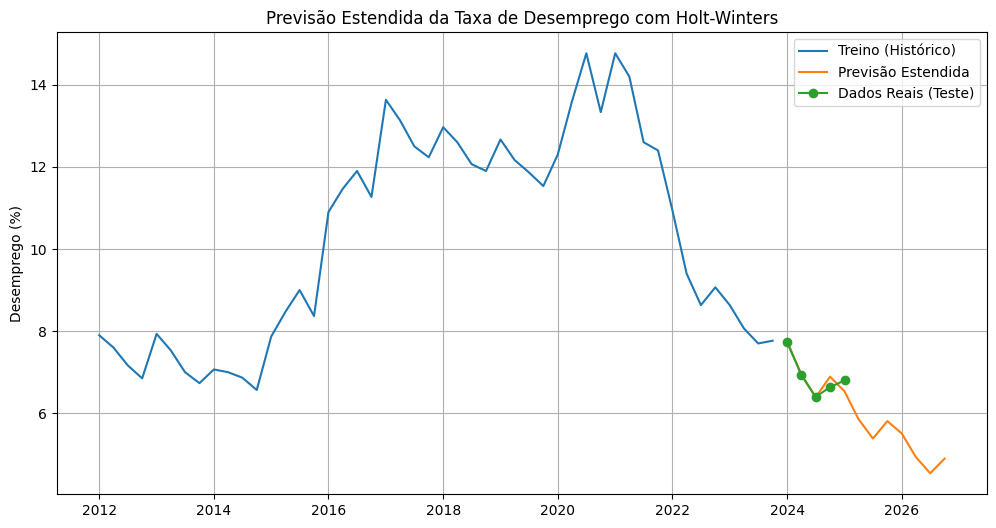

In [ ]:
# Novo período para previsão até 2026Q4
periodos_previsao_ext = pd.period_range('2024Q1', '2026Q4', freq='Q')
n_periodos_ext = len(periodos_previsao_ext)

# Fazer previsão estendida
previsao_ext = modelo.forecast(n_periodos_ext)

# Criar DataFrame das previsões estendidas
previsao_ext_df = pd.DataFrame({'Previsão': previsao_ext.values}, index=periodos_previsao_ext)

# Converter índice para datetime para plotar
previsao_ext_df.index = previsao_ext_df.index.to_timestamp()

# Plotar tudo junto: treino, dados reais (até 2025Q1) e previsão estendida
plt.figure(figsize=(12, 6))
plt.plot(serie_treino, label='Treino (Histórico)')
plt.plot(previsao_ext_df, label='Previsão Estendida')
plt.plot(dados_teste, label='Dados Reais (Teste)', marker='o')
plt.title('Previsão Estendida da Taxa de Desemprego com Holt-Winters')
plt.ylabel('Desemprego (%)')
plt.legend()
plt.grid(True)
plt.show()

**Resultado Observado**

Ao estendermos o período de projeção para **2025Q1 a 2026Q4**, observa-se que a **tendência de redução na taxa de desocupação é mantida**, com o indicador **convergindo para níveis entre 5,0% e 4,5% ao longo de 2026**. Essa trajetória está em linha com o padrão histórico captado durante o período de treinamento, sugerindo **uma continuidade da recuperação gradual do mercado de trabalho** no curto e médio prazo, à medida que os efeitos defasados da política monetária (como o aumento dos juros) começam a se dissipar e a atividade econômica ganha tração.

**Observações**

Vale ressaltar que, embora o modelo mantenha coerência com os dados observados nesse intervalo, **interpretações para além desse horizonte devem ser feitas com cautela**, pois o modelo passa a apresentar suavização excessiva, perda da sazonalidade e tendência a **convergir artificialmente a níveis próximos de zero**, comportamento matematicamente induzido pelas estruturas multiplicativas do modelo, mas **economicamente improvável** em horizontes longos.

#####**Limitações gerais do modelo**

Apesar de o modelo apresentar bom desempenho no curto prazo, quanto mais distante a previsão, maior a tendência de a série:

* Perder a sazonalidade aparente, suavizando as variações;

* Se aproximar de zero, por conta da multiplicação sucessiva de tendências e sazonalidades menores que 1 (o que pode ser irrealisticamente otimista no longo prazo).

Dessa forma, os resultados devem ser interpretados com cautela fora do intervalo de até 2 anos (8 trimestres), sendo mais indicados para análises de curto e médio prazo, como:

* Expectativas para a próxima reunião do Copom;

* Projeções orçamentárias e de políticas públicas;

* Planejamento de empresas sensíveis ao mercado de trabalho.